# Direct method
$$
    \left\{
    \begin{array}{l}
        \displaystyle \min - x_1(8), \\[0.5em]
        \dot{x}_1(t) = x_2(t) + \cos(u(t)), \; \text{for a.e. } t\in [0,8],\\[0.5em]
        \dot{x}_2(t) = \sin(u(t)),  \; \text{for a.e. } t\in [0,8], \\[0.5em]
        u(t) \in [-\frac{\pi}{2}, \frac{\pi}{2}], \; \text{for a.e. } t\in [0,8], \\[0.5em]
        x(0) = 0_{\mathbb{R}^2}, \quad x_2(8) = 4,\\[0.5em]
        \{x \in \mathbb{R}^2 \mid 0.5 < x_2 < 3.5 \} \text{ is a loss control region.}
    \end{array}
    \right.
$$

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min - x_1(8) + \epsilon\int_0^8 v^2(t)dt + \int_0^1 f_{NC}(x(t))u^2(t)dt, \\[0.5em]
        \dot{x}_1(t) = f_{C}(x(t))(x_2(t) + \cos(u(t))) + f_{NC}(x_2(t) + \cos(\lambda(t))), \; \text{for a.e. } t\in [0,8],\\[0.5em]
        \dot{x}_2(t) = f_{C}(x(t))\sin(u(t)) + f_{NC}(x(t))\sin(\lambda(t)),  \; \text{for a.e. } t\in [0,8], \\[0.5em]
        \dot{\lambda}(t) = f_{C}(x(t))v^2(t),  \; \text{for a.e. } t\in [0,8], \\[0.5em]

        u(t) \in [-\frac{\pi}{2}, \frac{\pi}{2}], \; \text{for a.e. } t\in [0,8], \\[0.5em]
        x(0) = 0_{\mathbb{R}^2}, \quad x_2(8) = 4,\\[0.5em]
        \{x \in \mathbb{R}^2 \mid 0.5 < x_2 < 3.5 \} \text{ is a loss control region.}
    \end{array}
    \right.
$$

In [1]:
using JuMP  
using Ipopt
using Plots
using Plots.PlotMeasures
using LaTeXStrings

In [2]:
mutable struct Direct
    t; x1; x2 ; λ ; u ; xu ; xv ; p1 ; p2
end

In [17]:
distance_squared(x, a, b) = x < a ? (a - x)^2 : x > b ? (x - b)^2 : 0 ;

#Moreau Yosida regularization

function MY_reg(x, a, b, k)
    return 1 - exp(-k*distance_squared(x, a, b))
end

fC(x) = MY_reg(x, 0.5, 3.5,2000)
fNC(x) = 1. - fC(x)

plot(fNC, 0., 1);

In [4]:
# second choise of regularization 
#function indicator(x, a, b)
#    k = 120 
#    g1 = 1 / (1 + exp(-k * (x - a)))  
#    g2 = 1 / (1 + exp(-k * (b - x)))  
#    return g1 * g2
#end
#fNC(x)  = indicator(x, 0.5, 3.5) ;
#fC(x)  = (1. - fNC(x));


In [4]:
function ZERMELO(x0, ε; solution=[], nsteps=500, display=true)
    
    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)
    
    N  = nsteps     # Grid size
    
    @variables(sys, begin
                x1[1:N+1]    
                x2[1:N+1]   
        -π/2  ≤  λ[1:N+1]  ≤ π/2
        -π/2  ≤  u[1:N+1]  ≤ π/2
        -1e2  ≤  v[1:N+1]  ≤ 1e2 
                xv[1:N+1]
                xu[1:N+1]
    end)
    
    
    Δt = 8/(N+1) ;
    
    # Objective
    @NLobjective(sys, Min, - x1[N+1] + ε*xv[N+1] + xu[N+1])
    
    # Boundary constraints
    @constraints(sys, begin
        con_xu0, xu[1]   == 0.0
        con_xv0, xv[1]   == 0.0
        con_x10, x1[1]   == x0[1] 
        con_x20, x2[1]   == x0[2] 
        con_x2f, x2[N+1] == 4.0                  
        con_x30, -π/2 <= λ[1]    <= π/2
        con_x3f, -π/2 <= λ[N+1]  <= π/2
        end)
    
    # Dynamics

    @NLexpression(sys, dx1[j = 1:N+1], fNC(x2[j])*(x2[j] + cos(λ[j])) + fC(x2[j])*(x2[j] + cos(u[j])))
    
    @NLexpression(sys, dx2[j = 1:N+1], fNC(x2[j])*sin(λ[j]) + fC(x2[j])*sin(u[j]) )
    
    @NLexpression(sys,  dλ[j = 1:N+1], fC(x2[j])*v[j])
    
    @NLexpression(sys, dxv[j = 1:N+1], v[j]^2)
    
    @NLexpression(sys, dxu[j = 1:N+1], fNC(x2[j])*u[j]^2)
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dx3[j=1:N],  λ[j+1] ==  λ[j] + 0.5 * Δt * (dλ[j+1]  + dλ[j])
        con_dxv[j=1:N], xv[j+1] == xv[j] + 0.5 * Δt * (dxv[j+1] + dxv[j])
        con_dxu[j=1:N], xu[j+1] == xu[j] + 0.5 * Δt * (dxu[j+1] + dxu[j])
    end);
    
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end
        
    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end    
        
    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    λ  = value.(λ)[:]
    u  = value.(u)[:]
    xu  = value.(xu)[:]
    xv  = value.(xv)[:]
    t  = (0:N) * value.(Δt)
    
    px10 =   dual(con_x10)
    px20 =   dual(con_x20)
    px2f = - dual(con_x2f)  # Modification : changement de signe

    # keep original signs for now
    sign = 1
    
     px1 = [ dual(con_dx1[i]) for i in 1:N ]
     px2 = [ dual(con_dx2[i]) for i in 1:N ]

     px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2.]; # We add the multiplier from the limit conditions
     px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2.; px2f]; # We add the multiplier from the limit conditions
    
     p1 = - [px10; px1[1:N] ]; # We add the multiplier from the limit conditions
     p2 = - [px20; px2[1:N-1]; px2f]; # We add the multiplier from the limit conditions

   
    return Direct(t, x1, x2, λ, u, xu, xv, p1, p2)
        
end;
     

In [5]:
# Resolution
x0  = [0.0; 0.0]
ε   = 1e-3
sol_direct = ZERMELO(x0, ε, nsteps=400);

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    12005
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:    13600

Total number of variables............................:     2807
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1203
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2005
Total number of in

┌ Warning: Function fNC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fNC, 1, fNC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370
┌ Warning: Function fC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fC, 1, fC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370


xu = 0.018124398108059842
xv = 0.0165037594938113


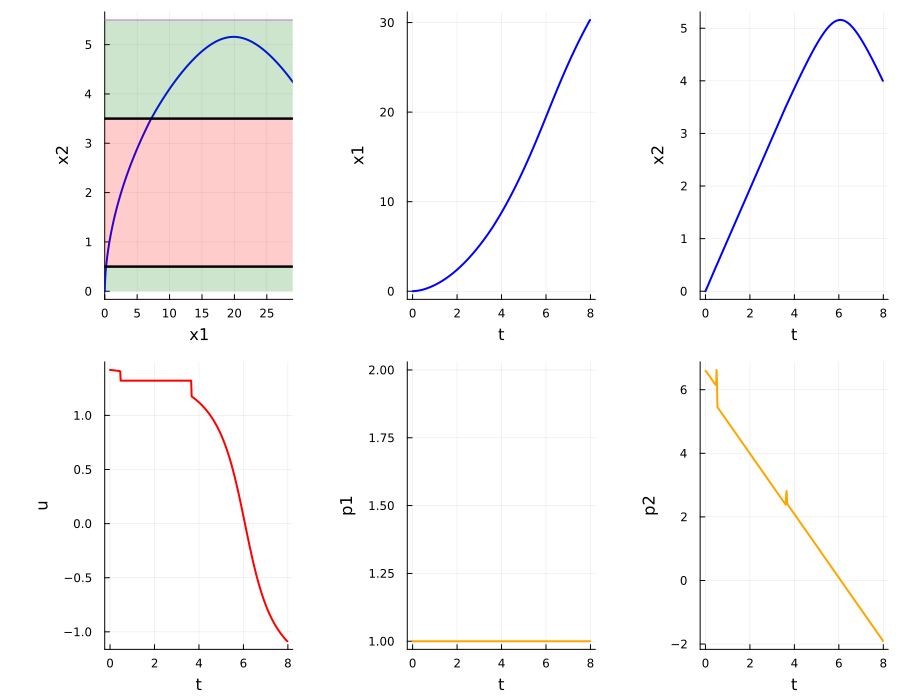

In [6]:
# Plots
t  = sol_direct.t
x1 = sol_direct.x1
x2 = sol_direct.x2
u  = sol_direct.u
λ  = sol_direct.λ
xu = sol_direct.xu
xv = sol_direct.xv
p1 = sol_direct.p1
p2 = sol_direct.p2

println("xu = ", xu[end])
println("xv = ", xv[end])

u1   = copy(u) ; 
index1 = findfirst(abs.(x2.- 0.5) .< 0.01)
index2 = findfirst(abs.(x2.- 3.5) .< 0.01)
t1   = t[index1-1]
t2   = t[index2+2]
u1[t1  .<= t .<= t2] .= λ[(index1 + index2) ÷ 2]


x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  legend= false, linecolor=:blue, linewidth=2)
p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1",  legend= false, linecolor=:orange, linewidth=2)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2",  legend= false, linecolor=:orange, linewidth=2)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2", legend= false,linecolor=:blue,linewidth=2)

u_plot   = plot(t,  u1, xlabel = "t", ylabel = "u",legend= false,linecolor=:red,linewidth=2)

λ_plot   = plot(t,  λ, xlabel = "t", ylabel = "λ", legend= false,linecolor=:red,linewidth=2)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend= false, linecolor=:blue,linewidth=2)
plot!(x1x2_plot, [0., 31.], [0.5, 0.5], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green)
plot!(x1x2_plot, [0., 31.], [3.5, 3.5], fillrange = 0.5, fillalpha = 0.2, fillcolor = :red)
plot!(x1x2_plot, [0., 31.], [5.5, 5.5], fillrange = 3.5, fillalpha = 0.2, fillcolor = :green)
hline!([(0., 0.5), (29., 0.5)], linecolor=:black, linewidth=2, label=false)
hline!([(0., 3.5), (29., 3.5)], linecolor=:black, linewidth=2, label=false)
xlims!(0, 29)

plot(x1x2_plot, x1_plot, x2_plot, u_plot , p1_plot, p2_plot , layout = (2,3), size=(900,700), left_margin=10mm)

In [7]:
jmp1 = p2[index1+2]  - p2[index1]
jmp2 = p2[index2+2]  - p2[index2]


0.4376744353049018

# Indirect method

In [8]:
using NLsolve
using Animations
using Reel
using Plots
using Plots.PlotMeasures
include("flow.jl");
using LinearAlgebra;

In [9]:
# Dynamics
function F(x, u)
    return [ x[2] + cos(u[1]), sin(u[1]) ]
end

function G(λ)
    return [ sin(λ), - cos(λ) ]
end

# Hamiltonians: permanent region
H1(x, u, p)  = p' * F(x, u)               # pseudo-Hamiltonian
u11(x, p)    = atan(p[2]/p[1])
Hc(x, p)     = H1(x, u11(x, p) , p )      # control

# Flows
fc  = Flow(Hc);

# Hamiltonians: control loss region
H2(x, λ, y, p)   = p' * F(x, λ)   + y* p' *G(λ)          # pseudo-Hamiltonian
Hcl(X, P)     = H2(X[1:2], X[3], X[4], P[1:2])           # control loss

# Flows
fcl  = Flow(Hcl);

In [10]:
t0  = 0.0
tf  = 8.0
x2f = 4.0
x0  = [0.0; 0.0]



# Shooting function
function shoot(p0, tt1, tt2, λ, jump1, jump2) 
    
    pλ0    = 0.0 
    
    py0    = 0.0
    
    x1, p1 = fc(t0, x0, p0, tt1)
    
    X2, P2 = fcl(tt1, [x1; λ ; 0.0], [p1 - [0. , jump1]; pλ0 ; py0], tt2) # flow augmenté
    
    xf, pf = fc(tt2, X2[1:2], P2[1:2] - [0. , jump2], tf)

    s = zeros(eltype(p0), 7)
    s[1]  = xf[2] - x2f # target
    s[2]  = pf[1] - 1.0 # transversality condition
    s[3]  = x1[2] - 0.5 # first crossing 
    s[4]  = X2[2] - 3.5 # second crossing 
    s[5]  = P2[4]       # averaged gradient condition
    s[6]  = jump1 - p1[2]*(λ - u11(x1, p1))/(λ - x1[1])                # jump 1
    s[7]  = jump2 - P2[2]*(u11(X2[1:2], P2[1:2]) - λ)/(λ - X2[1])      # jump 2

    
    return s

end;

In [11]:
S(ξ)    = shoot(ξ[1:2], ξ[3], ξ[4], ξ[5], ξ[6], ξ[7]) ;

In [12]:
ξ_guess = [p1[1], p2[1], t1[1], t2[1], λ[100], jmp1, jmp2] ; # initial guess

In [13]:
println("Initial value of shooting:\n", S(ξ_guess), "\n\n") ;

Initial value of shooting:
[2.1397051024989713, 0.0, -0.02703626465533593, 0.04674904761052234, 1.3861851521705193, -0.6983471075345002, 0.44497069727627936]




In [14]:
# Solve

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0   = indirect_sol.zero[1:2]
    tt1   = indirect_sol.zero[3]
    tt2   = indirect_sol.zero[4]
    a     = indirect_sol.zero[5]
    jmp11 = indirect_sol.zero[6]
    jmp22 = indirect_sol.zero[7]

else
    error("Not converged")
end;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.139705e+00              NaN
     1     2.861573e-01     1.312732e+00
     2     5.229968e-03     1.763892e-01
     3     1.056065e-06     8.343313e-04
     4     1.204960e-13     3.811085e-07
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0, 6.588108390709012, 0.47880299251870323, 3.650872817955112, 1.3212139250570798, -1.1691042652729724, 0.4376744353049018]
 * Zero: [1.0, 5.864224581817986, 0.5078962137988892, 3.596687472709074, 1.3304421275469418, -0.26816536144285075, 0.05916036982325239]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5


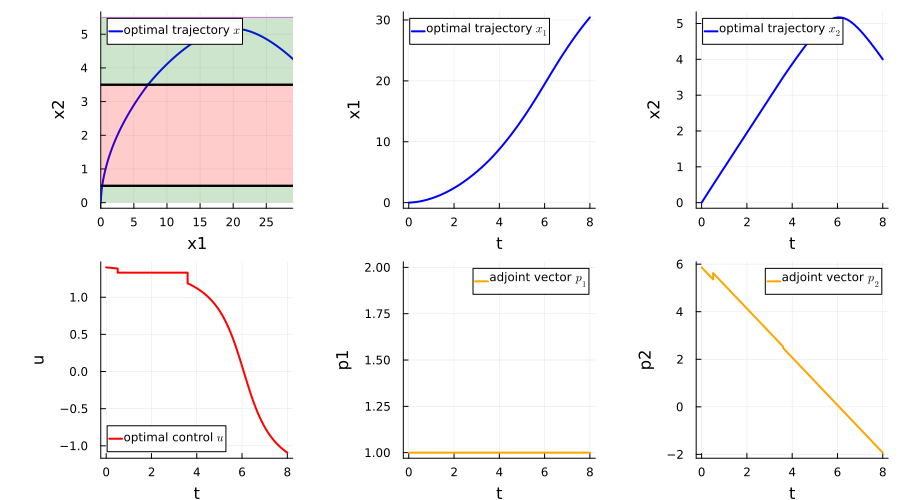

In [15]:
ode_sol = fc((t0, tt1), x0, pp0, saveat=0.1) ;
ttt1 = ode_sol.t ;
xx1 = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1 = [ ode_sol[3:4, j] for j in 1:size(ttt1, 1) ] ;
uu1 = u11.(xx1, pp1)  ;

pλ0 = 0. 
py0 = 0.

ode_sol = fcl((tt1, tt2), [xx1[end] ; a ; 0.0], [pp1[end] - [0. , jmp11]; pλ0 ; py0], saveat=0.1)
ttt2 = ode_sol.t
xx2 = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ]
pp2 = [ ode_sol[5:6, j] for j in 1:size(ttt2, 1) ]
uu2 = a.*ones(length(ttt2)) ;

ode_sol = fc((tt2, tf), xx2[end], pp2[end] - [0. , jmp22], saveat=0.1)
ttt3 = ode_sol.t
xx3 = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ]
pp3 = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] 
uu3 = u11.(xx3, pp3)  ;

t = [ ttt1 ; ttt2 ; ttt3 ]
x = [ xx1 ; xx2 ; xx3 ]
p = [ pp1 ; pp2 ; pp3 ]
u = [ uu1 ; uu2 ; uu3 ]

m = length(t)

x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  label=L"optimal trajectory $x_1$", linecolor=:blue, linewidth=2)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2", label=L"optimal trajectory $x_2$",linecolor=:blue,linewidth=2)

p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", label=L"adjoint vector $p_1$",linecolor=:orange, linewidth=2)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", label=L"adjoint vector $p_2$",linecolor=:orange,linewidth=2)
u_plot    = plot(t,   u, xlabel = "t", ylabel = "u", label=L"optimal control $u$" ,linecolor=:red ,linewidth=2, legend=:bottomleft) 




x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  label=L"optimal trajectory $x$", linecolor=:blue,linewidth=2)
plot!(x1x2_plot, [0., 31.], [0.5, 0.5], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green, label=false)
plot!(x1x2_plot, [0., 31.], [3.5, 3.5], fillrange = 0.5, fillalpha = 0.2, fillcolor = :red, label=false)
plot!(x1x2_plot, [0., 31.], [5.5, 5.5], fillrange = 3.5, fillalpha = 0.2, fillcolor = :green, label=false)
hline!([(0., 0.5), (29., 0.5)], linecolor=:black, linewidth=2, label=false)
hline!([(0., 3.5), (29., 3.5)], linecolor=:black, linewidth=2, label=false)
xlims!(0, 29)

x =plot(x1x2_plot,x1_plot, x2_plot,u_plot,p1_plot, p2_plot , layout = (2, 3), size=(900, 500), left_margin=10mm)




In [17]:
# create an animation
animx = @animate for i = 1:length(t)
    plot(x1[1:i], x2[1:i], xlim=(0.,31.), ylim=(-0.,5.5), xlabel="x1", ylabel="x2", label="optimal trajectory \$x\$", linecolor=:blue,  linewidth=2)
    scatter!([x1[i]], [x2[i]], markersize=4, marker=:circle, color=:black, label=false)
    plot!( [0., 31.], [0.5, 0.5], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green, label=false)
    plot!( [0., 31.], [3.5, 3.5], fillrange = 0.5, fillalpha = 0.2, fillcolor = :red, label=false)
    plot!( [0., 31.], [5.5, 5.5], fillrange = 3.5, fillalpha = 0.2, fillcolor = :green, label=false)

end

# create an animation
animu = @animate for i = 1:length(t)
    plot(t[1:i], u[1:i], xlim=(0.,8.), ylim=(-pi/2,pi/2), xlabel="t", ylabel="u", label="opitmal control \$u\$", linecolor=:red,  linewidth=2)
end ;

# create an animation
animp1 = @animate for i = 1:length(t)
    plot(t[1:i], p1[1:i], xlim=(0.,8.), ylim=(0.,2.), xlabel="t", ylabel="p1", label="adjoint vector \$p1\$", linecolor=:orange,  linewidth=2)
end ;

# create an animation
animp2 = @animate for i = 1:length(t)
    plot(t[1:i], p2[1:i], xlim=(0.,8.), ylim=(-2.2,6.), xlabel="t", ylabel="p2", label="adjoint vector \$p2\$", linecolor=:orange,  linewidth=2)
end ;

[ Info: Saved animation to /home/anas/Documents/control-loss/zermelo/zer1_x.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/zermelo/zer1_x.gif")
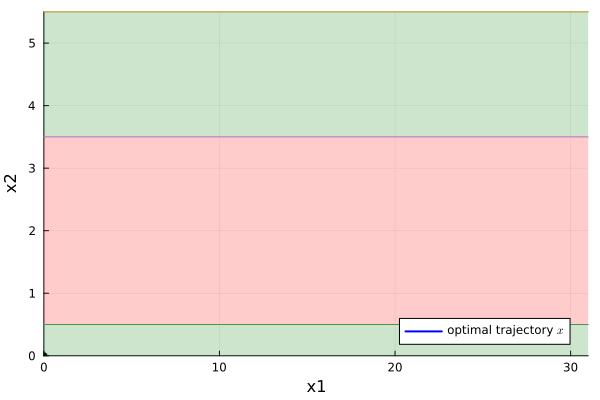

In [18]:
# display the animation
gif(animx, "zer1_x.gif", fps = 10)

[ Info: Saved animation to /home/anas/Documents/control-loss/zermelo/zer1_u.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/zermelo/zer1_u.gif")
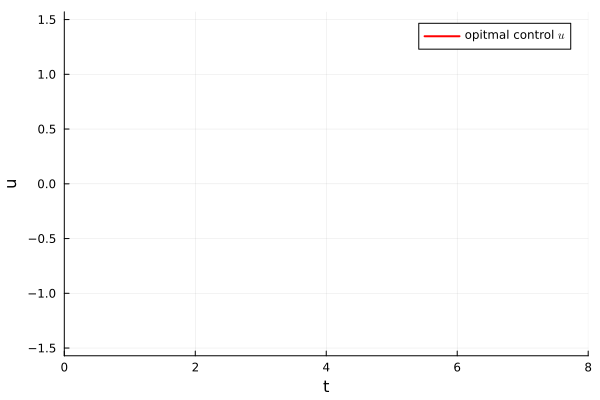

In [19]:
gif(animu, "zer1_u.gif", fps = 10)

[ Info: Saved animation to /home/anas/Documents/control-loss/zermelo/zer1_p1.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/zermelo/zer1_p1.gif")
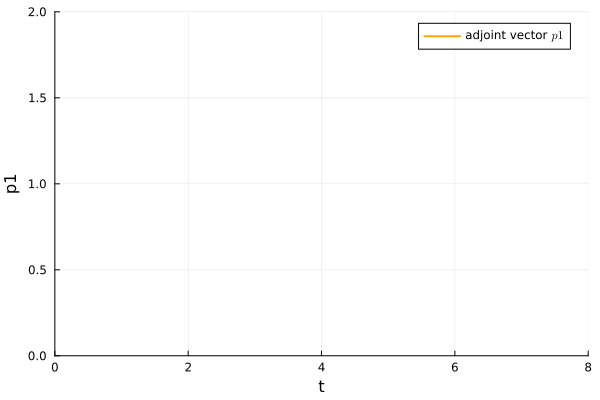

In [20]:
# display the animation
gif(animp1, "zer1_p1.gif", fps = 10)

[ Info: Saved animation to /home/anas/Documents/control-loss/zermelo/zer_p2.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/zermelo/zer_p2.gif")
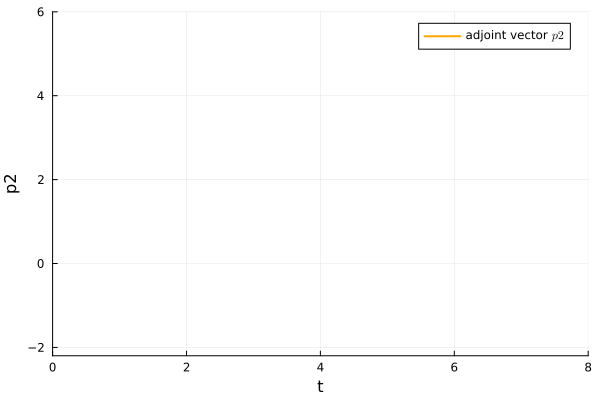

In [21]:
# display the animation
gif(animp2, "zer_p2.gif", fps = 10)